# MLOps for NLP

## Understanding the problem 

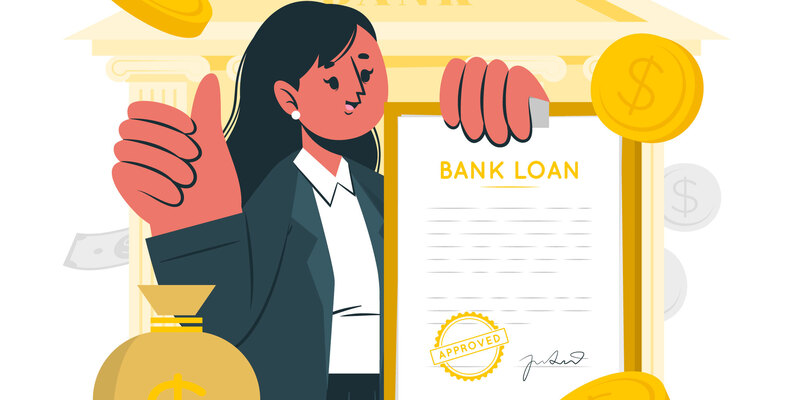

## Bank Loan Approval Prediction
We will learn the basics of MLOps using a simple use case of Loan Approval. We will start with data preprocessing till all the way upto deployment of the ML model 

## Setup

In [37]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached mlflow-2.14.1-py3-none-any.whl (25.8 MB)
  Using cached xgboost-2.1.0-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
  Using cached ray-2.30.0-cp310-cp310-manylinux2014_x86_64.whl (66.0 MB)
  Using cached starlette-0.37.2-py3-none-any.whl (71 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached dvc-3.51.2-py3-none-any.whl (452 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.18.1%2Bcpu-cp310-cp310-linux_x86_64.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.3.1%2Bcpu-cp310-cp310-linux_x86_64.whl (1.7 MB)
  Using cached intel_extension_for_pytorch-2.3.0-cp310-cp310-manylinux2014_x86_64.whl (98.3 MB)
  Using cached 

  Using cached gto-1.7.1-py3-none-any.whl (46 kB)
  Using cached dvc_http-2.32.0-py3-none-any.whl (12 kB)
  Using cached ruamel.yaml-0.18.6-py3-none-any.whl (117 kB)
  Using cached pathspec-0.12.1-py3-none-any.whl (31 kB)
  Using cached iterative_telemetry-0.0.8-py3-none-any.whl (10 kB)
  Using cached dvc_data-3.15.1-py3-none-any.whl (71 kB)
  Using cached https://download.pytorch.org/whl/colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached platformdirs-3.11.0-py3-none-any.whl (17 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached dvc_studio_client-0.20.0-py3-none-any.whl (16 kB)
  Using cached celery-5.4.0-py3-none-any.whl (425 kB)
  Using cached psutil-6.0.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (290 kB)
  Using cached configobj-5.0.8-py2.py3-none-any.whl (36 kB)
  Using cached dvc_render-1.0.2-py3-none-any.whl (22 kB)
  Using cached dv

  Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  Using cached aiohttp_retry-2.8.3-py3-none-any.whl (9.8 kB)
  Using cached click_repl-0.3.0-py3-none-any.whl (10 kB)
  Using cached click_didyoumean-0.3.1-py3-none-any.whl (3.6 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached billiard-4.2.0-py3-none-any.whl (86 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
  Using cached atpublic-4.1.0-py3-none-any.whl (5.0 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl (16 kB)
  Using cached graphql_core-3.2.3-py3-none-any.whl (202 kB)
  Using cached typer-0.12.3-py3-none-any.whl (47 kB)
  Using cached amqp-5.2.0-py3-none-any.whl (50 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached importlib_metadata-7.1.0-py3-none-any.whl (24 kB)
  Using cached opentelemetry_semantic_conventions-0.46b0-py3-none-any.whl (130 kB)
  Using cached pygit2-1.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.1

  Using cached email_validator-2.2.0-py3-none-any.whl (33 kB)
  Using cached fastapi_cli-0.0.4-py3-none-any.whl (9.5 kB)
  Using cached httptools-0.6.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (341 kB)
  Using cached nest_asyncio-1.6.0-py3-none-any.whl (5.2 kB)
  Using cached comm-0.2.2-py3-none-any.whl (7.2 kB)
  Using cached jupyter_core-5.7.2-py3-none-any.whl (28 kB)
  Using cached jupyter_client-8.6.2-py3-none-any.whl (105 kB)
  Using cached debugpy-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl (214 kB)
  Using cached textual-0.70.0-py3-none-any.whl (562 kB)
  Using cached jupyterlab_pygments-0.3.0-py3-none-any.whl (15 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
  Using cached mistune-3.0.2-py3-none-any.whl (47 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.

  Using cached jupyter_server_terminals-0.5.3-py3-none-any.whl (13 kB)
  Using cached jupyter_lsp-2.2.5-py3-none-any.whl (69 kB)
  Using cached async_lru-2.0.4-py3-none-any.whl (6.1 kB)
  Using cached Babel-2.15.0-py3-none-any.whl (9.6 MB)
  Using cached json5-0.9.25-py3-none-any.whl (30 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (86 kB)
  Using cached mdit_py_plugins-0.4.1-py3-none-any.whl (54 kB)
  Using cached linkify_it_py-2.0.3-py3-none-any.whl (19 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
  Using cached arrow-1.3.0-py3-none-any.whl (66 kB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 16.1.0
    Uninstalling pyarrow-16.1.0:
      Successfully uninstalled pyarrow-16.1.0
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.2.2
    Uninstalling platformdirs-4.2.2:
      Successfully uninstall

## Data 

In [38]:
import pandas as pd

In [39]:
## Dataset link - https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
DATASET = './data/loan_approval_dataset.csv'

In [40]:
df = pd.read_csv(DATASET)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### Exploratory Data Analysis 

In [41]:
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns 

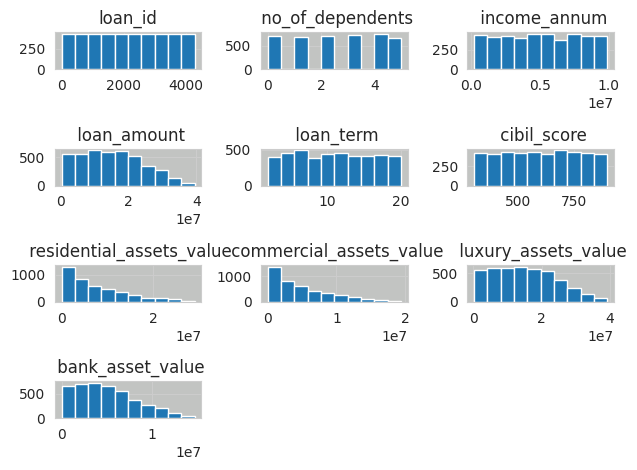

In [42]:
# Most commong tags
df.hist()
# plt.figure(figsize=(40, 22))  # Adjust the width and height as needed
plt.tight_layout()  # Optional: Improve spacing between subplots
plt.show()

In [43]:
# Renaming the column
df = df.rename(columns = {col_name: col_name.strip() for col_name in df.columns}) # Stripping the column name
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [44]:
df.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

In [45]:
df['education'].value_counts()

education
 Graduate        2144
 Not Graduate    2125
Name: count, dtype: int64

### Data Preprocessing

In [46]:
from sklearn.model_selection import train_test_split 

In [47]:
df.loan_status.value_counts()

loan_status
 Approved    2656
 Rejected    1613
Name: count, dtype: int64

In [48]:
df_processed = df.copy()

In [49]:
# One hot encoding 
def convert_to_onehot(x):
    if x.strip().lower() == 'graduate':    # 1 - Graduate, 0 Not Graduate    
        return 1 
    return 0 

df_processed['education'] = df_processed['education'].apply(convert_to_onehot)
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,0,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,1,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,1,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,0,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [50]:
# One hot encoding 
def convert_to_onehot(x):
    if x.strip().lower() == 'approved':    # 1 - Graduate, 0 Not Graduate    
        return 1 
    return 0 

df_processed['loan_status'] = df_processed['loan_status'].apply(convert_to_onehot)
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,2,0,0,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,3,1,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,4,3,1,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,5,0,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [51]:
# One hot encoding 
def convert_to_onehot(x):
    if x.strip().lower() == 'yes':    # 1 - Graduate, 0 Not Graduate    
        return 1 
    return 0 

df_processed['self_employed'] = df_processed['self_employed'].apply(convert_to_onehot)
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,2,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,4,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


### Feature Engineering

In [52]:
df_processed['total_asset'] = df_processed['luxury_assets_value'] + df_processed['commercial_assets_value'] + df_processed['residential_assets_value'] 
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,total_asset
0,1,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,42700000
1,2,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,13700000
2,3,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,44900000
3,4,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,44800000
4,5,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,50000000


## DVC

In [53]:
!dvc init --subdir

ERROR: failed to initiate DVC - '.dvc' exists. Use `-f` to force.


In [54]:
!dvc add data/loan_approval_dataset.csv
!git add.dvc/config
!git commit -m "Added dataset"

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/akarx/MLOps/ML/.dvc/cache/files/md5'| |0/? [00:00<
                                                                                
!
  0%|          |Checking out /home/akarx/MLOps/ML/data0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 74.01file/s]

To track the changes with git, run:

	git add data/loan_approval_dataset.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
git: 'add.dvc/config' is not a git command. See 'git --help'.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .

In [55]:
!dvc dag

+------------------------------------+ 
| data/loan_approval_dataset.csv.dvc | 
+------------------------------------+ 


## Experiment tracking with MLFlow

### Setting up mlflow

In [56]:
import mlflow

In [57]:
experiment_name = "loan approval"
mlflow.set_tracking_uri(uri="http://localhost:8080")
# experiment_id = mlflow.set_experiment(experiment_name).experiment_id 
if not mlflow.get_experiment_by_name(experiment_name):
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
print(experiment_id)

121968206584279418


In [58]:
mlflow.get_experiment_by_name(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/121968206584279418', creation_time=1719337466752, experiment_id='121968206584279418', last_update_time=1719337466752, lifecycle_stage='active', name='loan approval', tags={}>

In [59]:
from xgboost import XGBClassifier 
import mlflow 
from sklearn.metrics import accuracy_score
from mlflow.models import infer_signature 
import warnings
warnings.filterwarnings('ignore')

In [60]:
dataset = mlflow.data.from_pandas(
    df_processed, name="Loan Approval Dataset", targets="loan_status"
)

In [61]:
test_size = 0.2 
train_df, val_df = train_test_split(df_processed, stratify=df.loan_status, test_size=test_size, random_state=1234) 

In [62]:
X_train = train_df.drop(columns = ['loan_status'], axis = 1) 
y_train = train_df['loan_status']

In [63]:
X_val = val_df.drop(columns = ['loan_status'], axis = 1) 
y_val = val_df['loan_status']

In [64]:
xgb_classifier = XGBClassifier(
    n_estimators=10, 
    max_depth=3, 
    learning_rate=1, 
    objective="binary:logistic", 
    random_state=123, 
)


In [65]:
with mlflow.start_run(experiment_id=experiment_id, run_name="initial experiment"):
    mlflow.log_input(dataset, context="training")
    xgb_classifier.fit(X_train, y_train) 
    clf_params = xgb_classifier.get_xgb_params() 
    mlflow.log_params(clf_params) 
    signature = infer_signature(X_train, xgb_classifier.predict(X_train))   # What is this infer_signature
    model_info = mlflow.xgboost.log_model(
        xgb_classifier, "loan classification", signature=signature
    ) 
    y_pred = xgb_classifier.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    mlflow.log_metric("accuracy", acc)

print("Accuracy achieved: ", acc)


Exception: Run with UUID fc0ac914795f4b00b8a650c9cdd37201 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [66]:
xgb_classifier_saved = mlflow.pyfunc.load_model(model_info.model_uri) 
y_pred = xgb_classifier_saved.predict(X_val)

In [67]:
y_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [68]:
acc = accuracy_score(y_val, y_pred)
mlflow.log_metric("accuracy", acc)

## Hyperparameters tuning using optuna

In [69]:
import math 
import numpy as np 
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

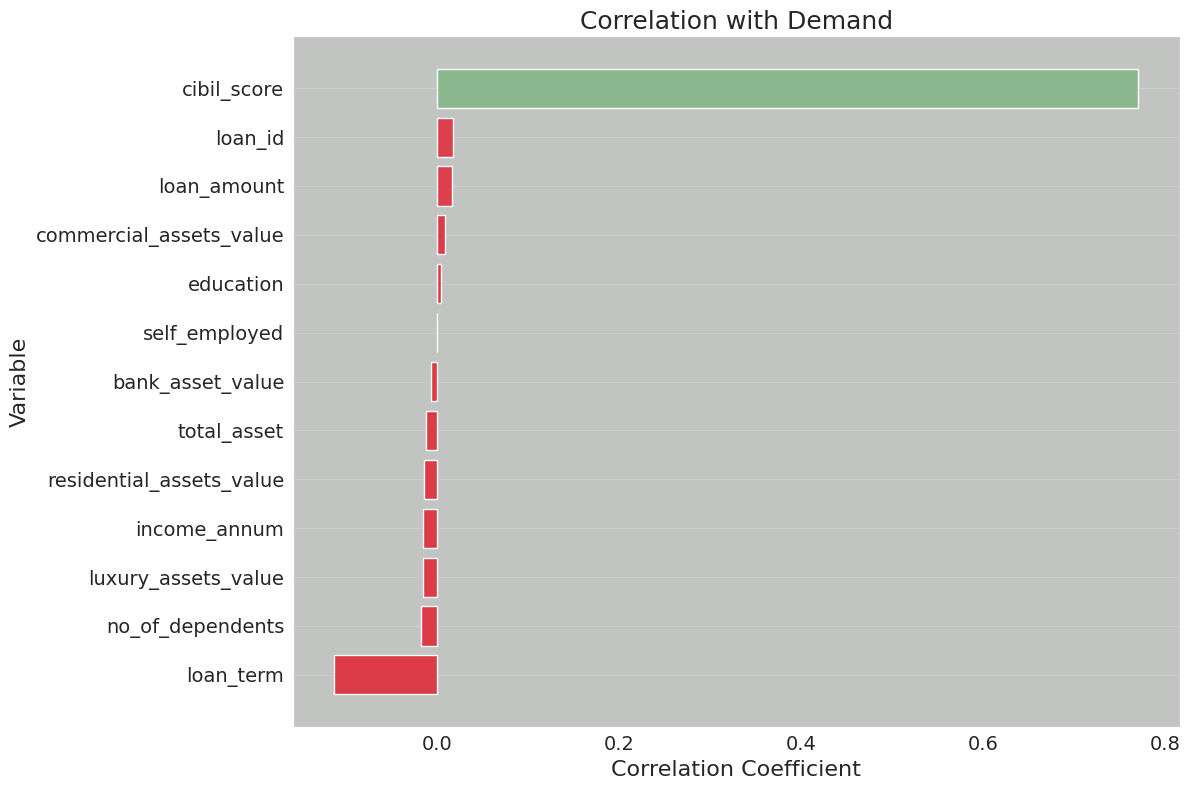

In [70]:
def plot_correlation(df, save_path=None): 
    """
    Plots the correlation of each variable in the dataframe with the demand column
    """
    correlations = df.corr()['loan_status'].drop('loan_status').sort_values()
    colors = sns.diverging_palette(10, 130, as_cmap=True) 
    color_mapped = correlations.map(colors) 

    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )

    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped) 

    plt.title("Correlation with Demand", fontsize=18) 
    plt.xlabel("Correlation Coefficient", fontsize=16) 
    plt.ylabel("Variable", fontsize=16) 
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.grid(axis="x")

    plt.tight_layout()

    # plt.show()
    return fig 

correlation_plot = plot_correlation(df_processed)
    

In [71]:
def plot_feature_importance(model, booster): 
    """
    Plost feature importance for an XGBoost model.
    """ 
    fig, ax = plt.subplots(figsize=(10, 8)) 
    importance_type = "weight" if booster == "gblinear" else "gain" 
    xgb.plot_importance(
        model, 
        importance_type=importance_type, 
        ax=ax, 
        title=f"Feature Importance based on {importance_type}", 
    )
    plt.tight_layout() 
    plt.show()


In [72]:
# override Optuna's default logging to ERROR only 
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [73]:
def objective(trial):
    # Define the hyperparameters to optimize
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 110),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        # 'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        # 'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        # 'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e-1),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-6, 1e-1),
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-6, 1e-1),
    }
    
    # Create XGBoost classifier with suggested hyperparameters
    clf = XGBClassifier(**param)
    
    # Evaluate model using cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
    # Return the negative mean accuracy because Optuna minimizes the objective function
    return -cv_scores.mean()

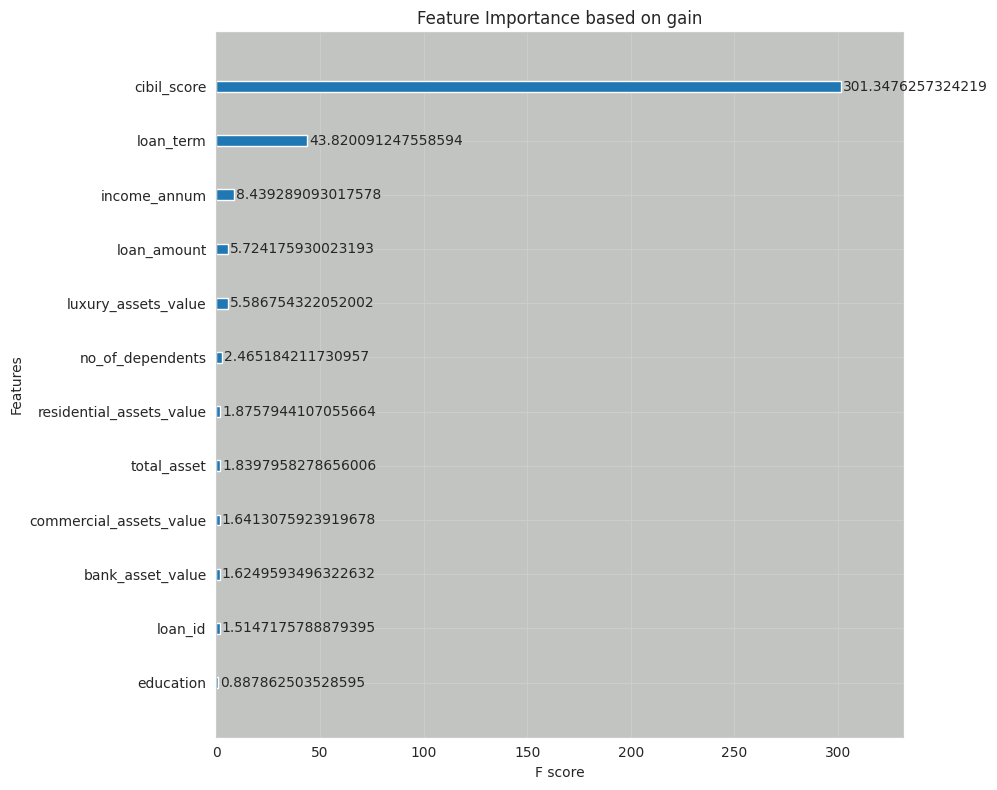

In [74]:
with mlflow.start_run(experiment_id=experiment_id, nested=True, run_name="hyperparameter_tune"):
    
    study = optuna.create_study(direction='minimize')

    study.optimize(objective, n_trials=5)
    
    mlflow.log_params(study.best_params) 
    mlflow.log_metric("acc", -study.best_value) 

    
    model = xgb.XGBClassifier(**study.best_params)
    model.fit(X_train, y_train)   #, eval_set=[(X_val, y_valid)], early_stopping_rounds=10, verbose=False)
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )
    
    
    preds = model.predict(X_val)
    # print(preds)
    preds = [1 if x>0.5 else 0 for x in preds]
    acc = accuracy_score(y_val, preds)

    model_uri = mlflow.get_artifact_uri(artifact_path)
    

In [75]:
print(model_uri)
loan_classifier = mlflow.xgboost.load_model(model_uri)

mlflow-artifacts:/121968206584279418/32b8c8a21aff446cb48a3df2a7575988/artifacts/model


## Model Registry

In [76]:
result = mlflow.register_model(
    model_uri, "xgboost-model"
)

Successfully registered model 'xgboost-model'.
2024/06/25 17:58:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost-model, version 1
Created version '1' of model 'xgboost-model'.


## Performance evaluation

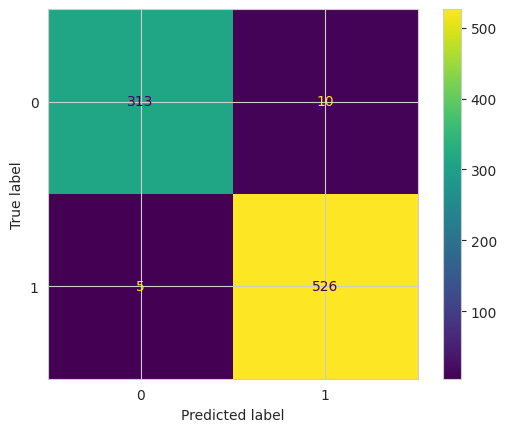

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = loan_classifier.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1])
disp.plot()
plt.show()

## Interpretability

In addition to comparing predicted results with actual values, we can also examine the inputs to our models. Which parts of the input influence the prediction the most? If the model is focusing on the wrong features, we need to investigate whether there's a hidden pattern we're missing or if the model is overfitting to incorrect features. Tools like SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) can help us understand feature importance. These tools show which features are most important by evaluating the model's performance without them. We can perform these inspections either broadly (e.g., for each class) or specifically (e.g., for a single prediction).







In [79]:
sample = X_val.iloc[0].values.reshape(1, -1).tolist()
model.predict(sample)
print(loan_classifier.predict_proba(sample))
print(y_val.iloc[0])


[[0.00321865 0.99678135]]
1


In [80]:
import lime.lime_tabular
import numpy as np
from sklearn.pipeline import make_pipeline

In [81]:
def classifier_fn(feature_values):
    y_output = loan_classifier.predict_proba(feature_values)
    return y_output

In [82]:
# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode='classification',
    feature_names=X_train.columns, 
    class_names=[0,1], 
    # discretize_continuous=True
)


In [83]:
instance = X_val.iloc[0].values.reshape(1, -1) 
# Explain the prediction
exp = explainer.explain_instance(
    data_row=instance[0], 
    predict_fn = classifier_fn

)

# Show the explanation
exp.show_in_notebook(show_table=True)

## Deployment

### Setting up ray

In [84]:
import ray
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

2024-06-25 18:07:16,182	WARNING __init__.py:21 -- Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.


In [85]:
if ray.is_initialized():
    ray.shutdown()

ray.init()
# Forward the port to see the logs

2024-06-25 18:07:19,209	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.24.0
Dashboard:,http://127.0.0.1:8265


(raylet) [2024-06-25 18:07:29,081 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4257943552; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:07:39,087 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4257931264; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:07:49,092 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4258123776; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:07:59,097 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4258127872; capacity: 468731568

(raylet) [2024-06-25 18:12:39,239 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4253626368; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:12:49,245 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4253618176; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:12:59,250 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4253618176; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:13:09,255 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4253614080; capacity: 468731568

(raylet) [2024-06-25 18:17:49,401 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4249645056; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:17:59,406 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4249645056; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:18:09,410 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4249628672; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:18:19,415 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4249591808; capacity: 468731568

(raylet) [2024-06-25 18:20:29,487 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4246859776; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:20:39,493 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4246859776; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:20:49,498 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4246851584; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:20:59,504 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4246851584; capacity: 468731568

(raylet) [2024-06-25 18:25:19,640 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4243374080; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:25:29,645 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4242579456; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:25:39,650 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4242571264; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:25:49,655 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4242567168; capacity: 468731568

(raylet) [2024-06-25 18:29:39,774 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4239171584; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:29:49,779 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4239171584; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:29:59,783 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4239167488; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:30:09,788 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4239163392; capacity: 468731568

(raylet) [2024-06-25 18:34:49,928 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4234420224; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:34:59,933 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4234416128; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:35:09,938 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4234412032; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:35:19,943 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4233924608; capacity: 468731568

(raylet) [2024-06-25 18:40:00,089 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4230148096; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:40:10,095 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4230148096; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:40:20,099 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4229218304; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:40:30,105 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4229218304; capacity: 468731568

(raylet) [2024-06-25 18:45:10,246 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4226961408; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:45:20,251 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4225851392; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:45:30,256 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4225847296; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:45:40,261 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4225843200; capacity: 468731568

(raylet) [2024-06-25 18:50:20,403 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4221943808; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:50:30,408 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4221943808; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:50:40,413 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4221939712; capacity: 468731568128. Object creation will fail if spilling is required.
(raylet) [2024-06-25 18:50:50,418 E 1601064 1601093] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-25_18-07-17_249149_1597637 is over 95% full, available space: 4221935616; capacity: 468731568

In [87]:
ray.cluster_resources()

{'node:10.138.187.90': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 128.0,
 'object_store_memory': 200000000000.0,
 'memory': 808736664576.0}

In [88]:
num_workers = 2 
resources_per_worker = {"CPU": 4}
MLFLOW_TRACKING_URI = "http://localhost:8080"

### Starlette 

In [89]:
from starlette.requests import Request

import ray
from ray import serve

In [93]:
@serve.deployment(num_replicas=2, ray_actor_options={'num_cpus':0.2, 'num_gpus':0})
class Model:
    def __init__(self):
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) 
        self.predictor = mlflow.xgboost.load_model(model_uri)
        
    def predict(self, input_data: list):
        # Perform prediction using the loaded model
        prediction = self.predictor.predict_proba(input_data)
        return {"prediction": prediction.tolist()}

    async def __call__(self, http_request: Request) -> str:
        data: str = await http_request.json() 
        return self.predict(data)


In [94]:
loan_predictor = Model.bind()

In [95]:
serve.run(loan_predictor)

2024-06-25 18:19:15,045	INFO handle.py:126 -- Created DeploymentHandle '1mvd3g0t' for Deployment(name='Model', app='default').
2024-06-25 18:19:15,047	INFO handle.py:126 -- Created DeploymentHandle '2uy3iy13' for Deployment(name='Model', app='default').
2024-06-25 18:19:21,096	INFO handle.py:126 -- Created DeploymentHandle '23yn2i2v' for Deployment(name='Model', app='default').
2024-06-25 18:19:21,097	INFO api.py:584 -- Deployed app 'default' successfully.
2024-06-25 18:19:21,104	INFO handle.py:126 -- Created DeploymentHandle 'j5c4rlrk' for Deployment(name='Model', app='default').
2024-06-25 18:19:21,105	INFO handle.py:126 -- Created DeploymentHandle '5e0eoapk' for Deployment(name='Model', app='default').
2024-06-25 18:19:21,106	INFO handle.py:126 -- Created DeploymentHandle 'dmid8m0t' for Deployment(name='Model', app='default').
2024-06-25 18:19:21,106	INFO handle.py:126 -- Created DeploymentHandle '2te6pkl6' for Deployment(name='Model', app='default').
2024-06-25 18:19:21,110	INFO ha

DeploymentHandle(deployment='Model')

## Inferencing the hosted server

In [99]:
import requests
import json

input_data = json.dumps({'input_data': X_val.iloc[0].values.reshape(1, -1).tolist()})

# print
# for i in range(100):
output = requests.post("http://127.0.0.1:8000/predict/", json=X_val.iloc[0].values.reshape(1,-1).tolist())
print(output.text)

{"prediction":[[0.0032186508178710938,0.9967813491821289]]}


### Handling multiple requests

In [100]:
import requests
import json

input_data = json.dumps({'input_data': X_val.iloc[0].values.reshape(1, -1).tolist()})

# print
for i in range(100):
    output = requests.post("http://127.0.0.1:8000/predict/", json=X_val.iloc[0].values.reshape(1,-1).tolist())
    print(output.text)

{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.9967813491821289]]}
{"prediction":[[0.0032186508178710938,0.